In [1]:
!pip install -q kaggle
import time
import zipfile
import os
import json
import cv2
import keras
import os

Using TensorFlow backend.


In [2]:
!pip install --upgrade keras

    100% |████████████████████████████████| 317kB 24.0MB/s 
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6


# NOW RESTART RUNTIME!

In [0]:
import keras

In [23]:
keras.__version__

'2.2.4'

In [21]:
from google.colab import files
files.upload()

{}

In [0]:
ROOT_DIR = os.path.abspath("/content/")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
start = time.time()
!kaggle competitions download airbus-ship-detection
print("downloading dataset took {} seconds".format(time.time()-start))

  0% 0.00/274k [00:00<?, ?B/s]
100% 274k/274k [00:00<00:00, 63.0MB/s]
 61% 11.0M/18.0M [00:00<00:00, 9.55MB/s]
100% 18.0M/18.0M [00:00<00:00, 20.3MB/s]
100% 2.12G/2.12G [01:22<00:00, 35.0MB/s]
100% 2.12G/2.12G [01:22<00:00, 27.7MB/s]
100% 26.4G/26.4G [20:56<00:00, 31.3MB/s]
100% 26.4G/26.4G [20:56<00:00, 22.6MB/s]
downloading dataset took 1348.6180775165558 seconds


In [8]:
for file in ["/content/test_v2.zip","/content/train_v2.zip","/content/train_ship_segmentations_v2.csv.zip"]:
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()
    print(file)

/content/test_v2.zip
/content/train_v2.zip
/content/train_ship_segmentations_v2.csv.zip


In [0]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv("/content/train_ship_segmentations_v2.csv").dropna()
display(df[:10])


,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
10,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
11,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
12,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [0]:
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util.montage import montage2d as montage

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)
  
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [12]:
!pip install mrcnn
from mrcnn.config import Config
from mrcnn import utils
import mrcnn
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from tqdm import tqdm

    100% |████████████████████████████████| 61kB 2.4MB/s 
  Running setup.py bdist_wheel for mrcnn ... - done
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


In [0]:
class ShipsDataset(mrcnn.utils.Dataset):
  def __init__(self,percentage_of_dataset=1):
    self.percentage_of_dataset = percentage_of_dataset
    self._image_ids = []
    self.image_info = []
    # Background is always the first class
    self.class_info = [{"source": "", "id": 0, "name": "BG"}]
    self.source_class_ids = {}
    
  def load_dataset(self, dataset_frame, width, height):
    self.dataset_frame = dataset_frame
    self.add_class("ships", 1, "ship")
    print("{} rows in dataframe".format(dataset_frame.shape[0]))
    for x in tqdm(dataset_frame.ImageId.unique()):
      ships = []
      for b in range(len(df.query('ImageId=="'+x+'"')['EncodedPixels'])):
        ships.append("ship")
      plt.imshow(cv2.imread(x))
      print(b)
      self.add_image("ship", image_id=x, path=x,
                    width=width, height=height,
                    ships=ships)
      
  
  def load_image(self,image_id):
    filename = self.dataset_frame.iloc[image_id].ImageId
    image = cv2.imread("/content/"+filename)
    return image
  
  def load_mask(self,image_id):
    info = self.image_info[image_id]
    ships = info['ships']
    filename = self.dataset_frame.iloc[image_id].ImageId
    rle_0 = df.query('ImageId=="'+filename+'"')['EncodedPixels']
    mask = masks_as_image(rle_0)
    print(ships)      
    class_ids = np.array([self.class_names.index(s) for s in ships])
    return mask.astype(np.bool), class_ids.astype(np.int32)
  
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['ships']

In [0]:
dataset_train = ShipsDataset(0.05)
dataset_train.load_dataset(df[:1000],768,768)

100%|██████████| 1/1 [00:00<00:00, 14.08it/s]

1 rows in dataframe
0


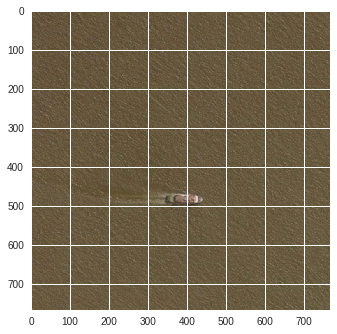

In [20]:
dataset_test = ShipsDataset(0.05)
dataset_test.load_dataset(df[:1],768,768)



In [0]:
dataset_train.prepare()
dataset_test.prepare()

189
['ship']


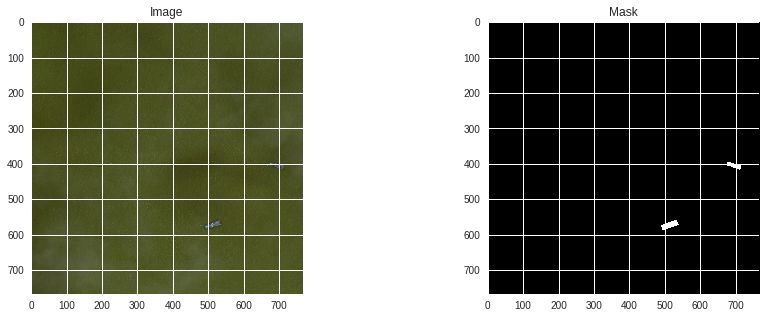

72
['ship', 'ship', 'ship']


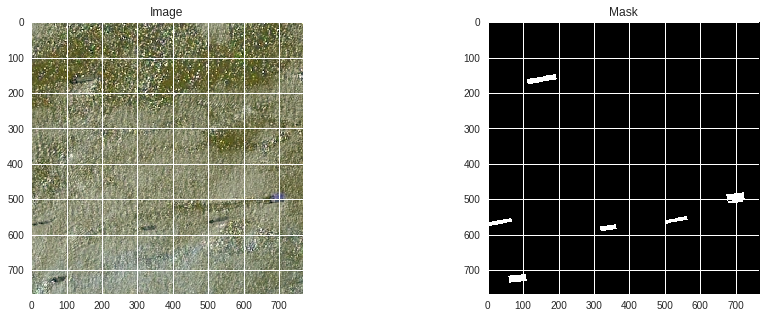

In [51]:
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
    print(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    ax1.imshow(image)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax2.imshow(mask[...,0], cmap='gray')
    plt.show()


In [0]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "ships"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 ships

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 768

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 500

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()

In [0]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [0]:
# Which weights to start with?
init_with = "imagenet"  # @param ["imagenet", "coco", "last"]

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [56]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_test, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/ships20181022T0708/mask_rcnn_ships_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
['ship']


ERROR:root:Error processing image {'id': 'ffd1999b4.jpg', 'source': 'ship', 'path': 'ffd1999b4.jpg', 'width': 768, 'height': 768, 'ships': ['ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1282, in load_image_gt
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
KeyError: 'ship'

['ship', 'ship', 'ship']
['ship']


['ship', 'ship', 'ship']
['ship']


ERROR:root:Error processing image {'id': '02d886255.jpg', 'source': 'ship', 'path': '02d886255.jpg', 'width': 768, 'height': 768, 'ships': ['ship', 'ship', 'ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1272, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 1ERROR:root:Error processing image {'id': 'ffd1999b4.jpg', 'source': 'ship', 'path': 'ffd1999b4.jpg', 'width': 768, 'height': 768, 'ships': ['ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1282, in load_image_gt
    so

['ship']
['ship']
['ship']
['ship']


ERROR:root:Error processing image {'id': 'ffa569440.jpg', 'source': 'ship', 'path': 'ffa569440.jpg', 'width': 768, 'height': 768, 'ships': ['ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1282, in load_image_gt
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
KeyError: 'ship'
ERROR:root:Error processing image {'id': 'fff77c602.jpg', 'source': 'ship', 'path': 'fff77c602.jpg', 'width': 768, 'height': 768, 'ships': ['ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1282, in load_image_gt
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id][

['ship']
['ship']
['ship']
['ship']


ERROR:root:Error processing image {'id': 'ffa569440.jpg', 'source': 'ship', 'path': 'ffa569440.jpg', 'width': 768, 'height': 768, 'ships': ['ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1282, in load_image_gt
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
KeyError: 'ship'
ERROR:root:Error processing image {'id': '02d772058.jpg', 'source': 'ship', 'path': '02d772058.jpg', 'width': 768, 'height': 768, 'ships': ['ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1282, in load_image_gt
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id][

['ship']
['ship', 'ship']
['ship', 'ship', 'ship', 'ship']
['ship', 'ship']


ERROR:root:Error processing image {'id': 'ffa71fd8e.jpg', 'source': 'ship', 'path': 'ffa71fd8e.jpg', 'width': 768, 'height': 768, 'ships': ['ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1282, in load_image_gt
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
KeyError: 'ship'
ERROR:root:Error processing image {'id': '02adb030b.jpg', 'source': 'ship', 'path': '02adb030b.jpg', 'width': 768, 'height': 768, 'ships': ['ship', 'ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1272, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not mat

['ship', 'ship', 'ship', 'ship']


ERROR:root:Error processing image {'id': '02adb030b.jpg', 'source': 'ship', 'path': '02adb030b.jpg', 'width': 768, 'height': 768, 'ships': ['ship', 'ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1272, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1
ERROR:root:Error processing image {'id': 'ffe2fcd0e.jpg', 'source': 'ship', 'path': 'ffe2fcd0e.jpg', 'width': 768, 'height': 768, 'ships': ['ship', 'ship', 'ship', 'ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1272, in loa

['ship', 'ship']
['ship', 'ship']


ERROR:root:Error processing image {'id': 'ffe2fcd0e.jpg', 'source': 'ship', 'path': 'ffe2fcd0e.jpg', 'width': 768, 'height': 768, 'ships': ['ship', 'ship', 'ship', 'ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1272, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 4 but corresponding boolean dimension is 1
ERROR:root:Error processing image {'id': '00ef1bc5c.jpg', 'source': 'ship', 'path': '00ef1bc5c.jpg', 'width': 768, 'height': 768, 'ships': ['ship', 'ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1272, in loa

['ship']


ERROR:root:Error processing image {'id': '00ef1bc5c.jpg', 'source': 'ship', 'path': '00ef1bc5c.jpg', 'width': 768, 'height': 768, 'ships': ['ship', 'ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1272, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1
ERROR:root:Error processing image {'id': 'ffa6115c2.jpg', 'source': 'ship', 'path': 'ffa6115c2.jpg', 'width': 768, 'height': 768, 'ships': ['ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1282, in load_image_gt
    source_cl

['ship']


['ship', 'ship']


ERROR:root:Error processing image {'id': 'ffa6115c2.jpg', 'source': 'ship', 'path': 'ffa6115c2.jpg', 'width': 768, 'height': 768, 'ships': ['ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1282, in load_image_gt
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
KeyError: 'ship'


['ship', 'ship']


ERROR:root:Error processing image {'id': '0005d01c8.jpg', 'source': 'ship', 'path': '0005d01c8.jpg', 'width': 768, 'height': 768, 'ships': ['ship', 'ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1272, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1ERROR:root:Error processing image {'id': '0005d01c8.jpg', 'source': 'ship', 'path': '0005d01c8.jpg', 'width': 768, 'height': 768, 'ships': ['ship', 'ship']}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1272, in load_image_gt
    cl

IndexError: ignored